# Optimización de hiperparámetros mediante algoritmos genéticos y evaluación final del modelo multimodal

### Objetivo

Encontrar la combinación óptima de tasa de aprendizaje, tamaño de lote y dimensión oculta del MLP de sensores usando un algoritmo genético, reentrenar el modelo con imágenes preprocesadas de 224x224 y datos de sensores, y validar su desempeño final a través de métricas (accuracy, precision, recall, F1-score) y matriz de confusión, garantizando una clasificación de salud de peces robusta y de alta precisión.

In [1]:
import sys
import os
# Agrega la raíz del proyecto al path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
# 0. Se Instala DEAP (antes de la importación):
# pip install deap

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

# DEAP para GA
from deap import base, creator, tools, algorithms

# Importación librerías personalizadas
from scripts.deap_pecesDataset import PecesDataset
from scripts.deap_loadAndSplit import load_and_split
from scripts.deap_MLPMultimodal import MLPMultimodal
#from scripts.deap_makeEvalFuntion import make_eval_function
from scripts.deap_runGeneticSearch import run_genetic_search
from scripts.deap_trainAndSaveBest import train_and_save_best
from scripts.deap_splitDataset import split_dataset


==> Usando dispositivo: cuda


In [3]:
import torch

print("torch.cuda.is_available():", torch.cuda.is_available())
print("torch.cuda.device_count():", torch.cuda.device_count())
print("torch.version.cuda:", torch.version.cuda)
print("torch.backends.cudnn.enabled:", torch.backends.cudnn.enabled)


torch.cuda.is_available(): True
torch.cuda.device_count(): 1
torch.version.cuda: 11.8
torch.backends.cudnn.enabled: True


### Configuración de datos

In [4]:
# Parámetros globales (rutas y columnas)
sensor_cols    = ['temperatura','pH','conductividad','TDS','DO_mgL']
label_col      = 'etiqueta_kmeans'
preproc_dir    = "../data/images_preproc"
label_csv      = "../data/labels2_kmeans_limpio.csv"
nombre_img_col = 'imagen'

In [5]:
# =========================
# 6) PIPELINE COMPLETO
# =========================
if __name__ == "__main__":
    # 6.1 Carga y split
    train_ds, val_ds = load_and_split()
    # 6.2 Búsqueda genética
    best = run_genetic_search(train_ds, val_ds,
                              n_classes=len(np.unique(pd.read_csv(label_csv)[label_col])),
                              pop_size=10, ngen=5,
                              cxpb=0.5,
                              mutpb=0.2,
                              sensor_cols=sensor_cols)
    
    # 6.3 Reentrenar y guardar mejor modelo
    train_and_save_best(best, 
                        train_ds, 
                        val_ds,
                        sensor_cols=sensor_cols,
                        label_csv=label_csv,
                        label_col=label_col, 
                        modelo_path="modelos/best_model_deap.pt")

GA Generations:  20%|██        | 1/5 [17:26<1:09:44, 1046.14s/it]

Gen 1/5 — avg: 0.9603, max: 0.9972


GA Generations:  40%|████      | 2/5 [22:43<30:51, 617.29s/it]   

Gen 2/5 — avg: 0.9742, max: 0.9972


GA Generations:  60%|██████    | 3/5 [26:36<14:44, 442.08s/it]

Gen 3/5 — avg: 0.9856, max: 0.9972


GA Generations:  80%|████████  | 4/5 [36:23<08:19, 499.34s/it]

Gen 4/5 — avg: 0.9861, max: 0.9972


GA Generations: 100%|██████████| 5/5 [46:20<00:00, 556.13s/it]


Gen 5/5 — avg: 0.9797, max: 0.9972

--- Mejor Individuo ---
lr = 0.008061
batch_size = 24
hidden_dim = 91
Fitness = 0.9972



Reentrenamiento:   5%|▌         | 1/20 [00:32<10:21, 32.72s/it]

Epoch 01 — train_loss: 0.4354, val_acc: 0.9767 ✅


Reentrenamiento:  10%|█         | 2/20 [01:00<08:51, 29.54s/it]

Epoch 02 — train_loss: 0.0551, val_acc: 0.9373 


Reentrenamiento:  15%|█▌        | 3/20 [01:27<08:08, 28.76s/it]

Epoch 03 — train_loss: 0.0565, val_acc: 0.9831 ✅


Reentrenamiento:  20%|██        | 4/20 [01:55<07:31, 28.22s/it]

Epoch 04 — train_loss: 0.0482, val_acc: 0.9817 


Reentrenamiento:  25%|██▌       | 5/20 [02:23<07:02, 28.15s/it]

Epoch 05 — train_loss: 0.0474, val_acc: 0.9887 ✅


Reentrenamiento:  30%|███       | 6/20 [02:50<06:30, 27.92s/it]

Epoch 06 — train_loss: 0.0425, val_acc: 0.9542 


Reentrenamiento:  35%|███▌      | 7/20 [03:18<06:01, 27.81s/it]

Epoch 07 — train_loss: 0.0459, val_acc: 0.9859 


Reentrenamiento:  40%|████      | 8/20 [03:47<05:37, 28.09s/it]

Epoch 08 — train_loss: 0.0360, val_acc: 0.9789 


Reentrenamiento:  45%|████▌     | 9/20 [04:14<05:06, 27.88s/it]

Epoch 09 — train_loss: 0.0389, val_acc: 0.9711 


Reentrenamiento:  50%|█████     | 10/20 [04:43<04:41, 28.11s/it]

Epoch 10 — train_loss: 0.0200, val_acc: 0.9930 ✅


Reentrenamiento:  55%|█████▌    | 11/20 [05:11<04:12, 28.09s/it]

Epoch 11 — train_loss: 0.0159, val_acc: 0.9979 ✅


Reentrenamiento:  60%|██████    | 12/20 [05:38<03:43, 27.89s/it]

Epoch 12 — train_loss: 0.0145, val_acc: 0.9951 


Reentrenamiento:  65%|██████▌   | 13/20 [06:05<03:13, 27.70s/it]

Epoch 13 — train_loss: 0.0138, val_acc: 0.9922 


Reentrenamiento:  70%|███████   | 14/20 [06:33<02:46, 27.80s/it]

Epoch 14 — train_loss: 0.0143, val_acc: 0.9937 


Reentrenamiento:  75%|███████▌  | 15/20 [07:01<02:18, 27.69s/it]

Epoch 15 — train_loss: 0.0130, val_acc: 0.9965 


Reentrenamiento:  80%|████████  | 16/20 [07:28<01:50, 27.60s/it]

Epoch 16 — train_loss: 0.0107, val_acc: 0.9937 


Reentrenamiento:  85%|████████▌ | 17/20 [07:55<01:22, 27.45s/it]

Epoch 17 — train_loss: 0.0107, val_acc: 0.9951 


Reentrenamiento:  90%|█████████ | 18/20 [08:23<00:54, 27.42s/it]

Epoch 18 — train_loss: 0.0106, val_acc: 0.9951 


Reentrenamiento:  95%|█████████▌| 19/20 [08:50<00:27, 27.41s/it]

Epoch 19 — train_loss: 0.0104, val_acc: 0.9951 


Reentrenamiento: 100%|██████████| 20/20 [09:18<00:00, 27.92s/it]

Epoch 20 — train_loss: 0.0102, val_acc: 0.9951 

🏁 Reentrenamiento completo. Mejor val_acc: 0.9979


In [6]:
# Lectura y preprocesamiento del DataFrame

# 1) Leemos todo el CSV
df = pd.read_csv(label_csv)

# 2) Convertimos las columnas de sensores a numérico y quitamos filas con NaNs
df[sensor_cols] = df[sensor_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=sensor_cols).reset_index(drop=True)

# 3) Extraemos el array de etiquetas para stratify
labels = df[label_col].values
#    -> Ejemplo: array(['enfermo','saludable','estres_leve', …], dtype=object)

# 4) Creamos el Dataset completo
full_ds = PecesDataset(
    df,                # el DataFrame filtrado y limpio
    preproc_dir,       # carpeta de imagenes "../data/images_preproc"
    sensor_cols,       # nombres de columna de sensores ['temperatura','pH',…]
    label_col,         # nombre de columna de etiquetas 'etiqueta_kmeans'
    nombre_img_col     # nombre de columna con el nombre de la imagen 'imagen'
)

# División en train/val/test

# 5) Llamada a la función de split:
train_ds, val_ds, test_ds = split_dataset(full_ds, labels,
                                          test_size=0.2, val_size=0.1)


In [12]:
# Preparar hiperparámetros óptimos

# 1) Valores hallados por el GA

best_lr = float(best[0])
best_bs = int(best[1])
best_hd = int(best[2])

print(f"Usando los siguientes hiperparámetros óptimos:")
print(f" - Learning rate : {best_lr:.6f}")
print(f" - Batch size    : {best_bs}")
print(f" - Hidden dim    : {best_hd}")

# 2) Preparar DataLoaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_ds, 
                          batch_size=best_bs, 
                          shuffle=True, 
                          pin_memory=(device.type=="cuda"))
val_loader   = DataLoader(val_ds,
                          batch_size=best_bs, 
                          shuffle=False, 
                          pin_memory=(device.type=="cuda"))
test_loader  = DataLoader(test_ds,  
                          batch_size=best_bs, 
                          shuffle=False, 
                          pin_memory=(device.type=="cuda"))

# 3) Instanciar modelo, optimizador y scheduler
model = MLPMultimodal(img_size=(224,224),
                      sensor_dim=len(sensor_cols),
                      hidden_dim=best_hd,
                      n_classes=len(pd.read_csv(label_csv)[label_col].unique())
                     ).to(device)
opt      = optim.Adam(model.parameters(), lr=best_lr)
loss_fn  = nn.CrossEntropyLoss()
sched    = optim.lr_scheduler.ReduceLROnPlateau(opt, 
                                                mode='max', 
                                                factor=0.5, 
                                                patience=3)

# Reentrenamiento final y recolección de métricas
# 4) Listas para almacenar métricas
train_losses = []
val_accs     = []

# Inicializamos variable para control del mejor accuracy
best_acc = 0.0

# 5) Reentrenamiento con tqdm y recolección de métricas
for epoch in trange(30, desc="Reentrenamiento Final"):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    for imgs, sens, ys in tqdm(train_loader, leave=False, desc=" Train batches"):
        imgs, sens, ys = imgs.to(device, non_blocking=True), \
                         sens.to(device, non_blocking=True), \
                         ys.to(device, non_blocking=True)
        opt.zero_grad()
        out = model(imgs, sens)
        loss = loss_fn(out, ys)
        loss.backward()
        opt.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validación
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for imgs, sens, ys in tqdm(val_loader, leave=False, desc=" Val batches"):
            imgs, sens = imgs.to(device, non_blocking=True), \
                                 sens.to(device, non_blocking=True)
            out = model(imgs, sens).argmax(dim=1).cpu().numpy()
            preds.extend(out)
            trues.extend(ys.numpy())
    val_acc = accuracy_score(trues, preds)
    val_accs.append(val_acc)

    # Scheduler y marcado de mejor época
    sched.step(val_acc)

    # — Aquí guardamos el mejor modelo —
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(
            model.state_dict(),
            "modelos/best_model_final.pt"
        )
        flag = "✅"  # marca en el print
    else:
        flag = ""

    print(f"Epoch {epoch+1:02d} — loss: {avg_loss:.4f}, val_acc: {val_acc:.4f} {flag}")


Usando los siguientes hiperparámetros óptimos:
 - Learning rate : 0.008061
 - Batch size    : 24
 - Hidden dim    : 91


Reentrenamiento Final:   3%|▎         | 1/30 [03:50<1:51:28, 230.65s/it]

Epoch 01 — loss: 0.4163, val_acc: 0.9789 ✅


Reentrenamiento Final:   7%|▋         | 2/30 [04:22<53:03, 113.70s/it]  

Epoch 02 — loss: 0.0531, val_acc: 0.9908 ✅


Reentrenamiento Final:  10%|█         | 3/30 [04:55<34:39, 77.03s/it] 

Epoch 03 — loss: 0.0582, val_acc: 0.9697 


Reentrenamiento Final:  13%|█▎        | 4/30 [05:28<25:43, 59.36s/it]

Epoch 04 — loss: 0.0481, val_acc: 0.9852 


Reentrenamiento Final:  17%|█▋        | 5/30 [06:00<20:41, 49.64s/it]

Epoch 05 — loss: 0.0383, val_acc: 0.9824 


Reentrenamiento Final:  20%|██        | 6/30 [06:33<17:31, 43.81s/it]

Epoch 06 — loss: 0.0426, val_acc: 0.9887 


Reentrenamiento Final:  23%|██▎       | 7/30 [07:06<15:30, 40.47s/it]

Epoch 07 — loss: 0.0285, val_acc: 0.9922 ✅


Reentrenamiento Final:  27%|██▋       | 8/30 [07:40<14:01, 38.25s/it]

Epoch 08 — loss: 0.0261, val_acc: 0.9951 ✅


Reentrenamiento Final:  30%|███       | 9/30 [08:13<12:49, 36.62s/it]

Epoch 09 — loss: 0.0284, val_acc: 0.9944 


Reentrenamiento Final:  33%|███▎      | 10/30 [08:45<11:48, 35.42s/it]

Epoch 10 — loss: 0.0235, val_acc: 0.9690 


Reentrenamiento Final:  37%|███▋      | 11/30 [09:19<10:59, 34.73s/it]

Epoch 11 — loss: 0.0239, val_acc: 0.9979 ✅


Reentrenamiento Final:  40%|████      | 12/30 [09:51<10:14, 34.15s/it]

Epoch 12 — loss: 0.0300, val_acc: 0.9930 


Reentrenamiento Final:  43%|████▎     | 13/30 [10:25<09:35, 33.86s/it]

Epoch 13 — loss: 0.0222, val_acc: 0.9930 


Reentrenamiento Final:  47%|████▋     | 14/30 [10:58<09:00, 33.76s/it]

Epoch 14 — loss: 0.0256, val_acc: 0.9986 ✅


Reentrenamiento Final:  50%|█████     | 15/30 [11:31<08:20, 33.35s/it]

Epoch 15 — loss: 0.0233, val_acc: 0.9972 


Reentrenamiento Final:  53%|█████▎    | 16/30 [12:03<07:42, 33.05s/it]

Epoch 16 — loss: 0.0209, val_acc: 0.9986 


Reentrenamiento Final:  57%|█████▋    | 17/30 [12:36<07:08, 32.96s/it]

Epoch 17 — loss: 0.0198, val_acc: 0.9937 


Reentrenamiento Final:  60%|██████    | 18/30 [13:09<06:36, 33.01s/it]

Epoch 18 — loss: 0.0226, val_acc: 0.9866 


Reentrenamiento Final:  63%|██████▎   | 19/30 [13:42<06:03, 33.04s/it]

Epoch 19 — loss: 0.0144, val_acc: 0.9922 


Reentrenamiento Final:  67%|██████▋   | 20/30 [14:14<05:28, 32.84s/it]

Epoch 20 — loss: 0.0146, val_acc: 0.9951 


Reentrenamiento Final:  70%|███████   | 21/30 [14:48<04:57, 33.08s/it]

Epoch 21 — loss: 0.0136, val_acc: 0.9965 


Reentrenamiento Final:  73%|███████▎  | 22/30 [15:18<04:18, 32.27s/it]

Epoch 22 — loss: 0.0134, val_acc: 0.9972 


Reentrenamiento Final:  77%|███████▋  | 23/30 [15:47<03:37, 31.11s/it]

Epoch 23 — loss: 0.0101, val_acc: 0.9993 ✅


Reentrenamiento Final:  80%|████████  | 24/30 [16:14<03:00, 30.10s/it]

Epoch 24 — loss: 0.0096, val_acc: 0.9930 


Reentrenamiento Final:  83%|████████▎ | 25/30 [16:42<02:26, 29.32s/it]

Epoch 25 — loss: 0.0105, val_acc: 0.9937 


Reentrenamiento Final:  87%|████████▋ | 26/30 [17:09<01:54, 28.68s/it]

Epoch 26 — loss: 0.0089, val_acc: 0.9993 


Reentrenamiento Final:  90%|█████████ | 27/30 [17:36<01:24, 28.21s/it]

Epoch 27 — loss: 0.0095, val_acc: 0.9937 


Reentrenamiento Final:  93%|█████████▎| 28/30 [18:03<00:55, 27.75s/it]

Epoch 28 — loss: 0.0080, val_acc: 0.9993 


Reentrenamiento Final:  97%|█████████▋| 29/30 [18:30<00:27, 27.52s/it]

Epoch 29 — loss: 0.0073, val_acc: 0.9986 


Reentrenamiento Final: 100%|██████████| 30/30 [18:57<00:00, 37.92s/it]

Epoch 30 — loss: 0.0075, val_acc: 0.9922 


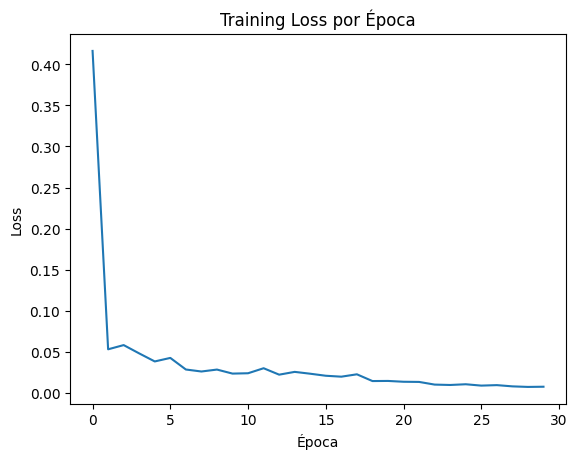

In [13]:
# 6) Gráfica de Training Loss
plt.figure()
plt.plot(train_losses)
plt.title("Training Loss por Época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.show()

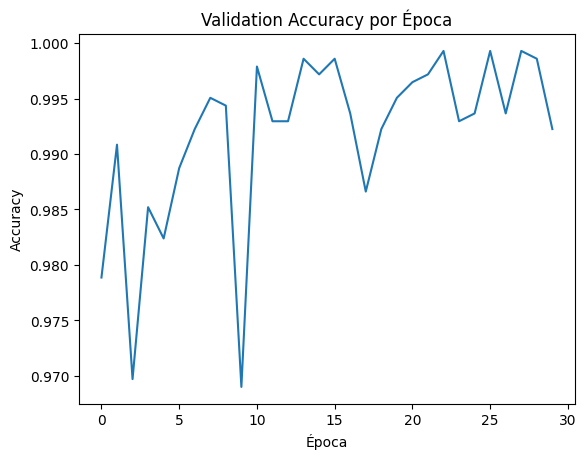

In [14]:
# 7) Gráfica de Validation Accuracy
plt.figure()
plt.plot(val_accs)
plt.title("Validation Accuracy por Época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.show()

In [15]:
# Evaluación final

# 1. Carga el checkpoint
checkpoint = torch.load("modelos/best_model_final.pt", map_location="cpu")

# 2. Extrae de él los parámetros de arquitectura
#   - hidden_dim = filas de mlp.0.weight
#   - sensor_dim = columnas de mlp.0.weight
#   - feat_plus_hd = columnas de classifier.0.weight  (feat_dim + hidden_dim)
#   - n_classes = filas de classifier.2.weight

hidden_dim    = checkpoint['mlp.0.weight'].shape[0]
sensor_dim    = checkpoint['mlp.0.weight'].shape[1]
feat_plus_hd  = checkpoint['classifier.0.weight'].shape[1]
n_classes     = checkpoint['classifier.2.weight'].shape[0]
feat_dim      = feat_plus_hd - hidden_dim

print("--- Parámetros extraídos del checkpoint ---")
print(f"hidden_dim  = {hidden_dim}")
print(f"sensor_dim  = {sensor_dim}")
print(f"feat_dim    = {feat_dim}")
print(f"n_classes   = {n_classes}\n")

# 3. Instancia del modelo en el dispositivo correcto
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPMultimodal(
    img_size=(224,224),      # asumiendo tu imagen de 224×224
    sensor_dim=sensor_dim,
    hidden_dim=hidden_dim,
    n_classes=n_classes
).to(device)

# 4. Carga de pesos y modo evaluación
model.load_state_dict(checkpoint)
model.eval()

# 5. Preparación del DataLoader de test
batch_size = int(checkpoint.get('batch_size',  best_bs if 'best_bs' in globals() else 32))
print(f"Usando batch_size = {batch_size} para evaluación final\n")
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=(device.type=="cuda")
)

# 6. Bucle de inferencia en el test set
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, sens, ys in tqdm(test_loader, desc="Evaluación Test"):
        imgs = imgs.to(device,   non_blocking=True)
        sens = sens.to(device,   non_blocking=True)
        out  = model(imgs, sens).argmax(dim=1).cpu().numpy()
        y_pred.extend(out)
        y_true.extend(ys.numpy())

# 7. Cálculo e impresión de métricas
acc   = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
cm    = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

print("\n--- Métricas en Test Set ---")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nMatriz de Confusión:\n", cm)
print("\nReporte de Clasificación:\n", report)


--- Parámetros extraídos del checkpoint ---
hidden_dim  = 91
sensor_dim  = 5
feat_dim    = 100352
n_classes   = 3

Usando batch_size = 24 para evaluación final



Evaluación Test: 100%|██████████| 119/119 [00:59<00:00,  2.00it/s]


--- Métricas en Test Set ---
Accuracy : 0.9993
Precision: 0.9993
Recall   : 0.9993
F1-score : 0.9993

Matriz de Confusión:
 [[1154    0    0]
 [   0  632    0]
 [   0    2 1049]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1154
           1       1.00      1.00      1.00       632
           2       1.00      1.00      1.00      1051

    accuracy                           1.00      2837
   macro avg       1.00      1.00      1.00      2837
weighted avg       1.00      1.00      1.00      2837



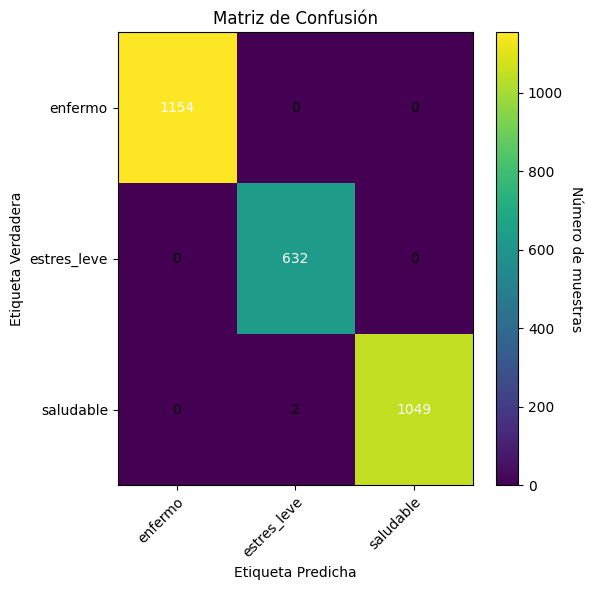

In [16]:
# == MATRIZ DE CONFUSIÓN ==

# Obtener nombres de clase

class_names = test_ds.dataset.classes  # ['enfermo', 'estres_leve', 'saludable']

# 1) Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

# 2) Crear la figura y el mapa de calor
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', aspect='auto')

# 3) Añadir la barra de color
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Número de muestras", rotation=-90, va="bottom")

# 4) Etiquetas de los ejes
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    title="Matriz de Confusión",
    xlabel="Etiqueta Predicha",
    ylabel="Etiqueta Verdadera"
)

# 5) Rotar etiquetas x 45 grados para evitar superposición
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# 6) Anotar cada celda con el valor
fmt = 'd'
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], fmt),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

# 7) Ajuste final y muestra
fig.tight_layout()
plt.show()